# PROJETO 1 - CLASSIFICADOR DE SENTIMENTO DO FILME JOKER
__________________________________________________________________________________________________________________

### Alunos:

Nome: Beatriz Cabral Fernandes 

Nome: Eduardo Ancona Mateus 


## 1. INTRODUÇÃO 

A proposta desse projeto é desenvolver um classificador que irá analisar como o público está reagindo ao premiado filme ***Joker***, do diretor *Todd Phillips*. Para isso, será utilizado como método o famoso algoritmo de Naive-Bayes.

## 2. DESENVOLVIMENTO E METODOLOGIA

A fim de simplificar a explicação do processo de desenvolvimento do projeto, ele será dividido em 6 etapas

### ETAPA 1 - Preparando o ambiente no Jupyter

Nessa etapa, serão baixadas e importadas todas as bibliotecas relevantes para o código, bem como implementadas todas as funções a serem utilizadas

In [1]:
%%capture

#Instalando o tweepy
!pip install tweepy

#Importando as bibliotecas
import tweepy
import math
import os.path
import pandas as pd
import json
from random import shuffle
from IPython.display import Image
import re
import matplotlib.pyplot as plt 
import numpy as np

#Repositório com as stopwords em portugues https://gist.github.com/alopes/5358189
#leitura de arquivo de texto com stopwords e outras palavra que nao convem ao projeto do dicionario portugues
with open('stopwords.txt','r') as arquivo:
    stopwords = arquivo.readlines()
#aqui é criada uma lista com as stopwords
stopwords = '\n'.join(stopwords).split()


#criando funcao de limpeza de caracteres
def cleanup(text):
    """
        Função de limpeza muito simples que troca alguns sinais básicos por espaços
    """
    #import string
    http = re.sub(r"http\S+", "", text)
    mention = re.sub("@[A-Za-z0-9]+","", http)
    punctuation = '[! - . : ? ; / _ # ) ( , \ " = ー — % « - @ -]' # Note que os sinais [] são delimitadores de um conjunto.
    pattern = re.compile(punctuation)
    text_subbed = re.sub(pattern, ' ', mention)
    return text_subbed

### ETAPA 2 - Autenticando no Twitter

Conta: `@datascience_dudle`


Nessa etapa será feita a autenticação no twitter, e posteriormente a coleta de tweets a partir de uma palavra chave. O código pode ser observado no arquivo [Projeto1_Obtenção_dos_tweets.ipynb](http://localhost:8888/notebooks/2%20Semestre%20-%20DP/CDADOS/P1_Cdados_BW/Projeto1_Obten%C3%A7%C3%A3o_dos_tweets.ipynb)

____________

### ETAPA 3 - Escolha de um produto e coleta das mensagens

No arquivo `Projeto1_Obtenção_dos_tweets.ipynb` foram coletados tweets relacionados ao filme ***Joker*** e salvos em na planilha do excel `Joker.xlsx`. Ao coletar os tweets com essa keyword, obtivemos 901 tweets para treinamento e 300 para teste. A seguir foi feita a leitura dos arquivos.

In [2]:
# Fazendo a leitura da planilha de treinamento
excel = pd.read_excel('Joker.xlsx', sheet_name='Treinamento')
excel_teste = pd.read_excel('Joker.xlsx', sheet_name='Teste')

In [3]:
excel_teste.head()

,Treinamento,Etiquetas
0,rt @_dcbrasil: maior ato do cinema de 2019! \n...,1
1,eu ñ fui assistir joker no cinema aqui pq so t...,3
2,@dracoh8 @caiquecerq @mateuscrz098 @joker_bsa ...,5
3,@joker_bsa @mitofaztd @portalprior mas o prior...,5
4,rt @itzguk: kpopper atacando o bts por tudo e ...,5


### ETAPA 4 - Classificação manual dos tweets

Vale ressaltar que o foco desse estudo é analisar o sentimento dos tweets relacionados ao premiado filme ***Joker***.
Desta forma, foram previamente estabelecidas 5 categorias para a classificação das mensagens:

* `P` - ***Crítica positiva*** – se a mensagem transmitida é uma crítica positiva;
* `N` - ***Crítica negativa*** – se a mensagem transmitida é uma crítica negativa;
* `I` - ***Irrelevante*** – se a mensagem transmitida estiver no contexto proposto, mas não for relevante para análise;
* `R` - ***Reação*** - se a mensagem transmitida trata-se de uma reação ou emoção em relação ao filme ou a uma cena;
* `F` - ***Fora do contexto*** - se a mensagem transmitida esta fora do contexto proposto.


Estabelecidas as categorias e selecionados os tweets, foi feita a leitura da base de treinamento, na qual as mensagens foram qualificadas manualmente no excel de acordo com a categoria mais adequada, bem como da base de teste. Conforme mostra a tabela a seguir:

In [4]:
excel.loc[:,'Etiquetas'] = excel['Etiquetas'].astype('category')
excel.Etiquetas.cat.categories = ['P','N','I','R','F']
excel.head()

,Treinamento,Etiquetas
0,mortos pelo regime genocida da china 100.000.0...,F
1,"@thiago_joker tempos de quarentena, sei lá né ...",F
2,se o governador do rio de janeiro candidatar p...,F
3,@jillajeeva332 @yutheesh0011 @joker_rowdy @pok...,F
4,galera só pra relembrar os filmes da dc de mai...,I


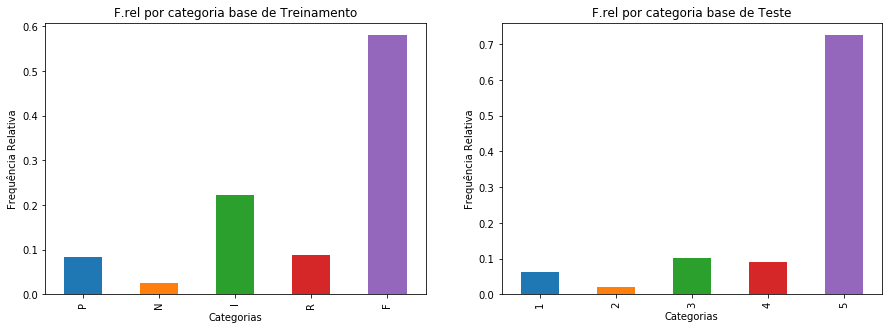

In [5]:
#Grafico para observar a distribuição das categorias P,N,I,R,F

fig = plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
t1 = pd.Series(excel.Etiquetas).value_counts(True).sort_index()
t1.plot(kind='bar')
plt.title('F.rel por categoria base de Treinamento')
plt.ylabel('Frequência Relativa')
plt.xlabel('Categorias')


plt.subplot(1, 2, 2)
t2 = pd.Series(excel_teste.Etiquetas).value_counts(True).sort_index()
t2.plot(kind='bar')
plt.title('F.rel por categoria base de Teste')
plt.ylabel('Frequência Relativa')
plt.xlabel('Categorias')

plt.show()

Acima, observa-se um número de tweets da categoria F muito grande em detrimento do resto das categorias. Por conta disso, vamos primeiro classificar os tweets em 2 principais categorias: como *Dentro do contexto (soma das categorias P,N,R e I)* ou *Fora do contexto (categoria F)*, a fim de minimizar o enviesamento do classificador e separar as mensagens consideradas "úteis" para nossa pesquisa. De maneira que neste primeiro momento temos estabelecidas:
* `D` - ***Dentro do contexto*** - se a mensagem transmitida esta dentro do contexto proposto;
* `F` - ***Fora do contexto*** - se a mensagem transmitida esta fora do contexto proposto.


In [6]:
excel1 = excel.apply(pd.Series.replace, to_replace=['P','N','I', 'R'] , value='D')
excel_teste.loc[:,'Etiquetas'] = excel_teste['Etiquetas'].astype('category')
excel_teste.Etiquetas.cat.categories = ['P','N','I','R','F']
excel_teste1 = excel_teste.apply(pd.Series.replace, to_replace=['P','N','I', 'R'] , value='D')
excel1.head()

,Treinamento,Etiquetas
0,mortos pelo regime genocida da china 100.000.0...,F
1,"@thiago_joker tempos de quarentena, sei lá né ...",F
2,se o governador do rio de janeiro candidatar p...,F
3,@jillajeeva332 @yutheesh0011 @joker_rowdy @pok...,F
4,galera só pra relembrar os filmes da dc de mai...,D


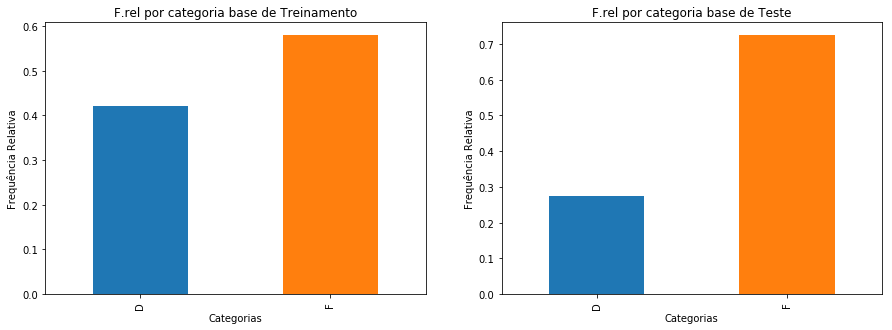

In [7]:
fig = plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
t3 = pd.Series(excel1.Etiquetas).value_counts(True).sort_index()
t3.plot(kind='bar')
plt.title('F.rel por categoria base de Treinamento')
plt.ylabel('Frequência Relativa')
plt.xlabel('Categorias')


plt.subplot(1, 2, 2)
t4 = pd.Series(excel_teste1.Etiquetas).value_counts(True).sort_index()
t4.plot(kind='bar')
plt.title('F.rel por categoria base de Teste')
plt.ylabel('Frequência Relativa')
plt.xlabel('Categorias')

plt.show()

No gráfico acima, pode-se observar a distribuição dos tweets entre as duas categorias estabelecidas.

### ETAPA 5 - Montando o Classificador Naive-Bayes

### Breve explicação de *Naive Bayes*
O algoritmo de *Naive Bayes* é um classificador probabilístico baseado no teorema de Bayes, utilizado no processo de machine learning. O algoritmo supõe que uma característica independe da outra para acontecer, ou seja, mesmo na presença de uma característica particular em uma classe, isso não afeta na probabilidade de qualquer característica ocorrer. O teorema de bayes é escrito da seguinte forma:

![title](img/bayes.png)

* $P(A)$ - Probabilidade a priori
* $P(B)$ - Probilidade Total
* $P(A|B)$ - posteriori
* $P(B|A)$ - verossimilhanca


Esse método será utilizado no projeto, uma vez que permite calcular, por exemplo, a probabilidade de uma mensagem receber diferentes classificações dado um tweet, assumindo que as palavras nele não tem nenhuma relação entre si.

A partir do nosso modelo, poderíamos reescrever o teorema de bayes da seguinte forma:

# $P(C|P) = \frac{P(P|C).P(C)}{P(P)}$

A variável C é a classe variável que representa a categoria de um tweet, a partir das condições estabelecidas (probabilidade de ocorrência de uma palavra dada as condições). A variável P representa as palavras ocorridas nos tweets.


P pode ser:

![title](img/bayes2.png)

Substituindo P por cada uma das possíveis palavras, temos:

![title](img/bayes3.png)

Nesse momento queremos classificar se um tweet está dentro ou fora do contexto do filme Joker. Para tanto é necessário analisar analisar as probabilidades.


Ou seja, precisa decidir se:

## $P(Dentro do contexto|frase) > P(Fora do contexto|frase)$



Utilizando o teorema de Bayes, temos:

## $P(D|frase) = \frac{P(frase|D)P(D)}{P(frase)}$

e que:

## $P(F|frase) = \frac{P(frase|F)P(F)}{P(frase)}$



Para implementar esse algoritmo, uma nova tabela deve ser criada com as palavras e suas respectivas frequências relativas em cada uma das categorias. Porém antes disso, deverá ser feita uma limpeza das mensagens, removendo pontuações e caracteres que não convém a análise.

In [8]:
# Verificando categorias do dataset
list(excel1)

['Treinamento', 'Etiquetas']

In [9]:
# Juntando todos os tweets da base de treinamento
texto_completo = cleanup(' '.join(excel1.Treinamento)).split()
texto_limpo = [word for word in texto_completo if word not in stopwords]

In [10]:
palavras_total = pd.Series(texto_limpo).value_counts() #lista com todas as palavras da base de treinamento

In [11]:
print('Número de palavras diferentes na base de treinamento inteira:', len(palavras_total))

Número de palavras diferentes na base de treinamento inteira: 4077


Fazendo uma breve análise dos termos mais frequentes, observa-se que alguns deles não são significantes para a nossa análise, e portanto deve-se ser feita a limpeza para nao prejudicar o resultado/performance. Exemplo:
- https 
- links e mencoes
- -
- rt
- /
- @

Além disso,foi feita uma limpeza das stopwords

### Definindo a probabilidade de cada uma das categorias

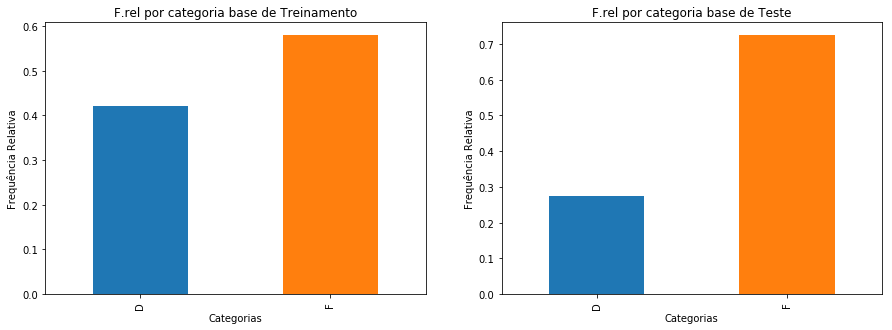

In [12]:
fig = plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
t3 = pd.Series(excel1.Etiquetas).value_counts(True).sort_index()
t3.plot(kind='bar')
plt.title('F.rel por categoria base de Treinamento')
plt.ylabel('Frequência Relativa')
plt.xlabel('Categorias')


plt.subplot(1, 2, 2)
t4 = pd.Series(excel_teste1.Etiquetas).value_counts(True).sort_index()
t4.plot(kind='bar')
plt.title('F.rel por categoria base de Teste')
plt.ylabel('Frequência Relativa')
plt.xlabel('Categorias')

plt.show()

In [13]:
prob_d = t3.D
prob_f = t3.F

Aqui, utilizaremos a funcao `Frequencia(n,excel,texto_limpo)` para além de limpar a base, calcular as frequencias de cada uma das categorias e suas respectivas probabilidades

In [15]:
def Frequencia(n,excel,texto_limpo):
    excel = excel
    texto_limpo = texto_limpo
    texto_completo_n = cleanup(' '.join(excel[excel.Etiquetas==n].Treinamento)).split() #y é uma lista com todas as palavras de cada categoria
    texto_limpo_n = [word for word in texto_completo_n if word not in stopwords]
    f_rel = pd.Series(texto_limpo_n).value_counts(True)
    f_abs = pd.Series(texto_limpo_n).value_counts()
    #prob = len(texto_limpo_n)/len(texto_limpo)
    return texto_limpo_n,f_rel,f_abs

In [16]:
d, rel_d, abs_d = Frequencia('D',excel1,texto_limpo)
f, rel_f, abs_f = Frequencia('F',excel1,texto_limpo)

In [17]:
print('Número de palavras diferentes na base de treinamento inteira:', len(rel_d+rel_f))

Número de palavras diferentes na base de treinamento inteira: 4077


Para calcular as probabilidades dos tweets dado as categorias, elaboramos a funcao `calcula_prob(n,excel_teste,excel,texto_limpo)`

In [18]:
def calcula_prob(n,excel_teste,excel,texto_limpo, prob):
    excel = excel
    prob = prob
    excel_teste = excel_teste
    texto_limpo = texto_limpo
    alpha = 1
    y,f_rel,f_abs = Frequencia(n,excel,texto_limpo)
    probTweetDadoN = []
    probNDadoTweet = []
    for t in excel_teste.Treinamento: #teste aq pq vou classificar pra depois comparar
        PTweetDadoN = 1 #para funcionar o loop que vai multiplicar todas as prob de cada palavra dado a cat
        tweet = cleanup(t).split()
        tweet_limpo = [word for word in tweet if word not in stopwords]
        num_pal_tot_cat = sum(f_abs)#numero de palavras total na categoria n 
        num_pal_pos = len(rel_d+rel_f) #numero de palavras possiveis na base de treinamento inteira
        for p in tweet_limpo:
            if p in f_rel:
                f_abs_cat = f_abs[p] # quantas vezes a palavra aparece no treino
            else: # se a palavra nao tiver na base de treino freq abs é igual a zero
                f_abs_cat = 0
            PPalavraDadoN = (alpha+f_abs_cat)/(num_pal_pos+num_pal_tot_cat) #probabilidade da palavra dado a categoria #elevei a 2 para as probabilidades nao ficarem mt pequenas
            PTweetDadoN = PTweetDadoN * PPalavraDadoN
        PNDadoTweet = prob*PTweetDadoN
        probTweetDadoN.append(PTweetDadoN) #add a probabilidade de cada tweet dado determinada categoria. 
        probNDadoTweet.append(PNDadoTweet)#Como estamos analisando uma mesma coluna, o len da lista de ambas as categorias vai ser igual, é tranquilo fazer uma lista
    return probTweetDadoN, probNDadoTweet


In [19]:
probTweetDadoD, probDDadoTweet= calcula_prob('D',excel_teste1,excel1,texto_limpo, prob_d)
probTweetDadoF, probFDadoTweet = calcula_prob('F',excel_teste1,excel1,texto_limpo, prob_f)

tenho uma lista com a probabilidade de cada tweet pra cada categoria, logo probDDadoTweet[i] é correspondente a probFDadoTweet[i]



In [20]:
class_tweet = []
for i in range(len(excel_teste1)):
    if probDDadoTweet[i]>probFDadoTweet[i]:
        class_tweet.append('D')
    else:
        class_tweet.append('F')


excel_teste1['class_auto'] = class_tweet
excel_teste1.head()

,Treinamento,Etiquetas,class_auto
0,rt @_dcbrasil: maior ato do cinema de 2019! \n...,D,D
1,eu ñ fui assistir joker no cinema aqui pq so t...,D,D
2,@dracoh8 @caiquecerq @mateuscrz098 @joker_bsa ...,F,F
3,@joker_bsa @mitofaztd @portalprior mas o prior...,F,F
4,rt @itzguk: kpopper atacando o bts por tudo e ...,F,D


### ETAPA 6 - Verificando a performance do classificador


Nesta etapa, iremos verificar a acurácia do nosso classificador. No gráfico a seguir é possível observar como se comporta a classificacao do nosso classificador

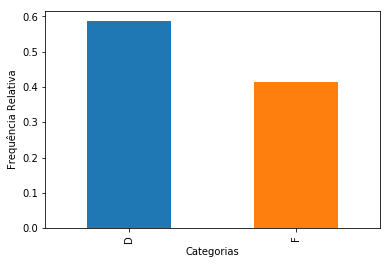

,class_auto
D,0.587248
F,0.412752


In [21]:
ct1 = pd.Series(excel_teste1.class_auto).value_counts(True).sort_index()
ct1.plot(kind='bar')
plt.ylabel('Frequência Relativa')
plt.xlabel('Categorias')
plt.show()
ct1.to_frame()

 Uma classificacao correta quer dizer que a categoria definida manualmente é igual a categoria definida pelo nosso classificador. Sendo assim, ao fazer um cruzamento das variáveis etiquetas e class_auto, obtemos a seguinte tabela: 

In [22]:
ct = pd.crosstab(excel_teste1.Etiquetas, excel_teste1.class_auto)
ct

class_auto,D,F
Etiquetas,,
D,73,9
F,102,114


Fazendo uma análise dela, é possivel calcular o numero de acertos e erros do classificador. Sendo que 
- quando class_auto = Etiquetas - significa que ele acertou
- quando class_auto diferente de Etiquetas - significa que ele errou


Logo:


In [23]:
acertos = ct.D['D'] + ct.F['F']
erros = ct.D['F'] + ct.F['D']
erros, acertos

(111, 187)

In [24]:
acuracia = acertos*100/(erros+acertos)
print('Acurácia do classificador: {0}%'.format(acuracia.round(3)))

Acurácia do classificador: 62.752%


A partir do resultado obtido, obeserva-se uma eficiência muito boa para detectar tweets da categoria 'D', em detrimento da categoria 'F'.

A seguir, vamos voltar ao objetivo inicial do projeto que era analisar como o público do filme Joker estava reagindo ao filme nas redes sociais. ou seja, vamos calcular a probabilidade do tweet ser P,N,I ou R dentre os tweets que estão dentro do contexto.

In [25]:
#criando um df apenas com as categorias dentro do contexto do filme
excel_d = excel[(excel.Etiquetas=='P') | (excel.Etiquetas=='N') | (excel.Etiquetas=='I') | (excel.Etiquetas=='R')]
excel_teste_d = excel_teste[(excel_teste.Etiquetas=='P') | (excel_teste.Etiquetas=='N') | (excel_teste.Etiquetas=='I') | (excel_teste.Etiquetas=='R')]
excel_d.head()

,Treinamento,Etiquetas
4,galera só pra relembrar os filmes da dc de mai...,I
5,@the_lem0s @leandro_peroni essa foi uma frase ...,R
7,19- the dark knight {assiste toda a trilogia} ...,P
9,dança da morte https://t.co/wpmkoltlss,I
11,finalmente vou assistir o joker carai,R


No gráfico a seguir, pode-se analisar como é distribuida a ocorrencia de cada uma das categorias dentro do contexto. Observa-se uma maior ocorrência de tweets irrelevantes e uma menor ocorrencia de tweets negativos, tanto na base de treinamento, quanto na base de teste.

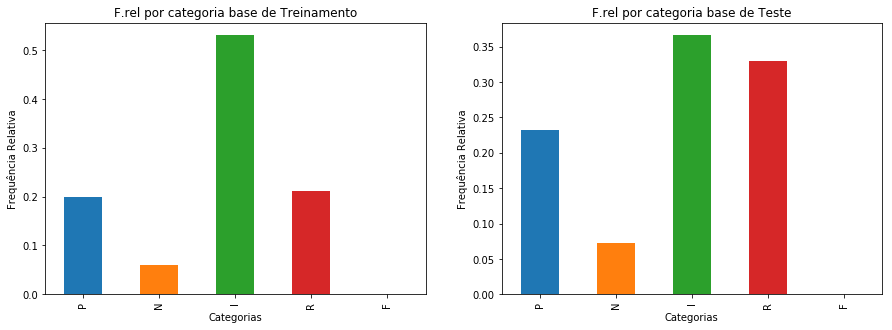

In [26]:
fig = plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
t3 = pd.Series(excel_d.Etiquetas).value_counts(True).sort_index()
t3.plot(kind='bar')
plt.title('F.rel por categoria base de Treinamento')
plt.ylabel('Frequência Relativa')
plt.xlabel('Categorias')


plt.subplot(1, 2, 2)
t4 = pd.Series(excel_teste_d.Etiquetas).value_counts(True).sort_index()
t4.plot(kind='bar')
plt.title('F.rel por categoria base de Teste')
plt.ylabel('Frequência Relativa')
plt.xlabel('Categorias')

plt.show()

In [27]:
prob_p = t3.P
prob_n = t3.N
prob_i = t3.I
prob_r = t3.R

In [28]:
texto_completo_d = cleanup(' '.join(excel_d.Treinamento)).split()
texto_limpo_d = [word for word in texto_completo_d if word not in stopwords]

In [29]:
p, rel_p, abs_p = Frequencia('P',excel_d,texto_limpo_d)
n, rel_n, abs_n = Frequencia('N',excel_d,texto_limpo_d)
i, rel_i, abs_i = Frequencia('I',excel_d,texto_limpo_d)
r, rel_r, abs_r = Frequencia('R',excel_d,texto_limpo_d)


In [30]:
probTweetDadoP, probPDadoTweet= calcula_prob('P',excel_teste_d,excel_d,texto_limpo_d, prob_p)
probTweetDadoN, probNDadoTweet = calcula_prob('N',excel_teste_d,excel_d,texto_limpo_d, prob_n)
probTweetDadoI, probIDadoTweet= calcula_prob('I',excel_teste_d,excel_d,texto_limpo_d, prob_i)
probTweetDadoR, probRDadoTweet = calcula_prob('R',excel_teste_d,excel_d,texto_limpo_d, prob_r)

In [31]:
class_tweet_d = []
for i in range(len(excel_teste_d)):
    maior = probPDadoTweet[i]
    class_tweet_d.append('P')
    if maior < probNDadoTweet[i]:
        maior = probNDadoTweet[i]
        class_tweet_d[i] = 'N'
    if maior < probIDadoTweet[i]:
        maior = probIDadoTweet[i]
        class_tweet_d[i] = 'I'
    if maior < probRDadoTweet[i]:
        maior = probRDadoTweet[i]
        class_tweet_d[i] = 'R'
    
    
excel_teste_d['class_auto'] = class_tweet_d
excel_teste_d.head()



/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,Treinamento,Etiquetas,class_auto
0,rt @_dcbrasil: maior ato do cinema de 2019! \n...,P,R
1,eu ñ fui assistir joker no cinema aqui pq so t...,I,I
5,fiz o joker e ficou uma merda,I,I
7,"queria assistir joker, mas não acho em nenhuma...",I,I
8,o cara deu risada da cena do joker no ônibus r...,R,R


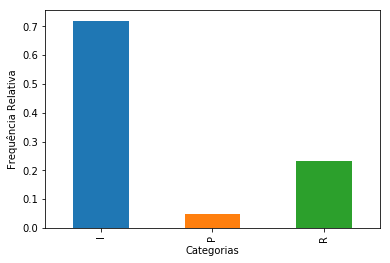

,class_auto
I,0.719512
P,0.048780
R,0.231707


In [35]:
ct2 = pd.Series(excel_teste_d.class_auto).value_counts(True).sort_index()
ct2.plot(kind='bar')
plt.ylabel('Frequência Relativa')
plt.xlabel('Categorias')
plt.show()
ct2.to_frame()

In [36]:
ct_d = pd.crosstab(excel_teste_d.Etiquetas, excel_teste_d.class_auto)
ct_d

class_auto,I,P,R
Etiquetas,,,
P,12,3,4
N,3,0,3
I,26,1,3
R,18,0,9


In [37]:
acertos_d = ct_d.P['P'] + ct_d.I['I'] + ct_d.R['R']#n tem n pq n foi class nenhum commo neg
acuracia_d = acertos_d*100/len(class_tweet_d)
print('Acurácia do classificador: {0}%'.format(acuracia_d.round(3)))


Acurácia do classificador: 46.341%


Observa-se uma baixa acurácia deste segundo classificador. Isso pode ser explicado pelo pequeno tamanho amostral, ou até mesmo pela desproporcionalidade entre uma categoria e outra, que pode gerar certo enviesamento.

## CONCLUSÃO

- Faça um comparativo qualitativo sobre os percentuais obtidos para que possa discutir a performance do seu classificador.
- Explique como são tratadas as mensagens com dupla negação e sarcasmo.
- Proponha um plano de expansão. Por que eles devem continuar financiando o seu projeto?


Opcionalmente:

- Discorrer por que não posso alimentar minha base de Treinamento automaticamente usando o próprio classificador, aplicado a novos tweets.

*Ao se utilizar o próprio classificador para gerar mais amostras de treinamento, o classificador acaba ficando 
'viciado', ou seja, acaba-se por prejudicar os resultados obtidos, e eles acabam não tendo uma qualidade boa.
Seria o contrário de coletar mais tweets, que melhora a qualidade dos dados e dos resultados, por ter um espaço 
amostral muito maior.*



- Propor diferentes cenários de uso para o classificador Naive-Bayes. Pense em outros cenários sem intersecção com este projeto.
- Sugerir e explicar melhorias reais no classificador com indicações concretas de como implementar (não é preciso codificar, mas indicar como fazer. Indique material de pesquisa sobre o assunto).

## BIBLIOGRAFIA

- https://towardsdatascience.com/naive-bayes-classifier-explained-50f9723571ed
- https://stackoverflow.com/questions/24399820/expression-to-remove-url-links-from-twitter-tweet/24399874
- https://stackoverflow.com/questions/54733828/remove-twitter-mentions-from-pandas-column
- https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/
- https://towardsdatascience.com/naive-bayes-classifier-explained-50f9723571ed